# Laboratory 01

## Exercise 1
Training a multi-linear classifier

In [1917]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

### 1.1
Write a function that reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files

In [1918]:
def load_file(filename):
    with open('dataset/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot_labels(labels, num_distincts=10):
    one_hot = np.zeros((num_distincts, len(labels)))
    for i, label in enumerate(labels):
        one_hot[label, i] = 1
    return one_hot

def LoadBatch(filename):
    dict = load_file(filename)
    images = dict[b'data'].T
    labels = dict[b'labels']
    labels_one_hot = one_hot_labels(labels)
    return images, labels_one_hot ,labels

In [1919]:
filetrain = 'data_batch_1'
fileval = 'data_batch_2'
filetest = 'test_batch'

X_train, labels_oh_train, labels_train = LoadBatch(filetrain)
X_val, labels_oh_val, labels_val = LoadBatch(fileval)
X_test, labels_oh_test, labels_test = LoadBatch(filetest)
batches = load_file('batches.meta')[b'label_names']
label_names = [lable_name.decode('utf-8') for lable_name in batches]

Label distribution in the three subsets

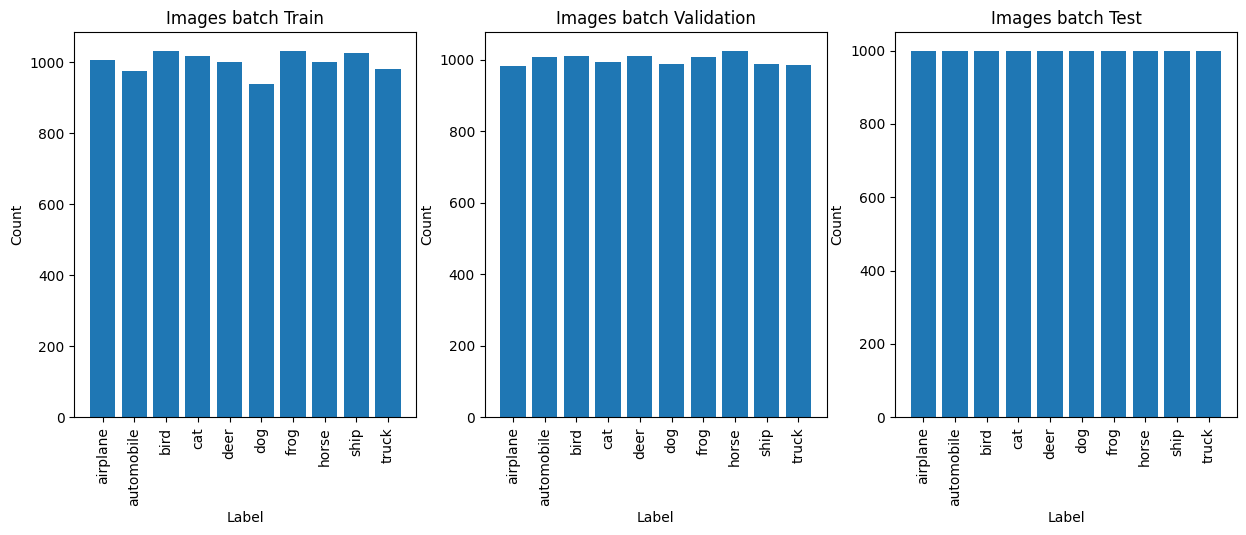

In [1920]:
labels_list = [labels_train, labels_val, labels_test]
names_list = ['Images batch '+str(i) for i in ['Train', 'Validation', 'Test']]
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (labels, name) in enumerate(zip(labels_list, names_list)):
    # Plot the histogram of the labels
    axes[i].bar(np.arange(10), np.bincount(labels), align='center', alpha=1)
    axes[i].set_title(name)
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(np.arange(10))
    axes[i].set_xticklabels(label_names, rotation=90)

### 1.2
Next we should pre-process the raw input data as it helps training. You should transform training data to have zero mean

In [1921]:
def preprocess_data(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    return (data - mean) / std

### 1.3
After reading in and pre-processing the data, you can initialize the parameters of the model W and b as you now know what size they should be

In [1922]:
def initialize_weights(input_dim, output_dim, seed=42, mean=0, std=0.01):
    #np.random.seed(seed)
    W = np.random.normal(mean, std, (output_dim, input_dim))
    #np.random.seed(seed)
    b = np.random.normal(mean, std, (output_dim, 1))

    return W, b

In [1923]:
input_dim = X_train.shape[0]
output_dim = labels_oh_train.shape[0]
W, b = initialize_weights(input_dim, output_dim)
W.shape, b.shape
print(W)

[[-0.00651786  0.00385985  0.00070475 ...  0.00332621  0.02814807
   0.00348684]
 [ 0.00333376 -0.00472171 -0.01930174 ... -0.00446102  0.00254311
  -0.01013527]
 [-0.00751627 -0.00673357 -0.00365043 ...  0.00431495  0.00408036
   0.00684132]
 ...
 [-0.01157909  0.00630458  0.0047351  ...  0.00740804 -0.00315616
  -0.0089477 ]
 [ 0.01221352  0.01068417 -0.01128368 ... -0.01331343 -0.00025538
   0.00953224]
 [-0.01278417 -0.0091013  -0.00598186 ... -0.00545418  0.00453613
   0.01002823]]


### 1.4
Write a function that evaluates the network function, i.e. equations (1, 2), on multiple images and returns the results

In [1924]:
def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def EvaluateClassifier(X, W, b):
    # eq 1,2
    s = W.dot(X) + b
    p = softmax(s)
    
    return p

In [1925]:
EvaluateClassifier(X_train[:,0:100], W, b).shape

(10, 100)

### 1.5
Write the function that computes the cost function given by equation for a set of images

In [1926]:
def computeCost(X, y, W, b, lamda):
    # eq 5
    p = EvaluateClassifier(X, W, b)
    # loss function term
    loss_cross = sum(-np.log((y*p).sum(axis=0)))
    # regularization term
    regularization = lamda * np.sum(W**2)
    # total cost
    J = loss_cross/X.shape[1] + regularization
    
    return J

### 1.6
Write a function that computes the accuracy of the network’s predictions on a set of data

In [1927]:
def computeAccuracy(X, y, W, b):
    # eq 4
    p = EvaluateClassifier(X, W, b)
    predictions = np.argmax(p, axis=0)
    accuracy = np.mean(predictions == y)
    
    return accuracy

### 1.7
Write the function that evaluates, for a mini-batch, the gradients of the cost function w.r.t. W and b

In [1928]:
def computeGradients(X, y, p, W, lamda):
    # eq 10, 11
    n = X.shape[1]
    C = y.shape[0]
    G = -(y-p)
    grad_W = (G@X.T)/n+2*lamda*W
    grad_b = (G@np.ones(shape=(n,1))/n).reshape(C,1)
    
    return grad_W, grad_b

Numerically computed gradient with finite difference method and centered difference formula (slower but more accurate)

In [1929]:
def computeGradsNum(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    # d = X.shape[0]
 
    grad_w = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))
 
    c = computeCost(X, Y, W, b, lamda)
 
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] += h
        c2 = computeCost(X, Y, W, b_try, lamda)
        grad_b[i] = (c2 - c) / h
 
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w_try = np.array(W)
            w_try[i, j] += h
            c2 = computeCost(X, Y, w_try, b, lamda)
            grad_w[i, j] = (c2 - c) / h
 
    return [grad_w, grad_b]

def computeGradsNumSlow(X, Y, P, W, b, lamda, h):
    no = W.shape[0]
 
    grad_w = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))
 
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = computeCost(X, Y, W, b_try, lamda)
 
        b_try = np.array(b)
        b_try[i] += h
        c2 = computeCost(X, Y, W, b_try, lamda)
 
        grad_b[i] = (c2 - c1) / (2 * h)
 
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w_try = np.array(W)
            w_try[i, j] -= h
            c1 = computeCost(X, Y, w_try, b, lamda)
 
            w_try = np.array(W)
            w_try[i, j] += h
            c2 = computeCost(X, Y, w_try, b, lamda)
 
            grad_w[i, j] = (c2 - c1) / (2 * h)
 
    return [grad_w, grad_b]

Check difference between numerical and analytical gradient for the first 20 dimensions of the first training example

In [1930]:
X = X_train[0:10000, [0]]
y = labels_oh_train[:, [0]]
lamda = 0

p = EvaluateClassifier(X, W[:,0:10000], b)
grad_w_analytic, grad_b_analytic = computeGradients(X, y, p, W[:,0:10000], lamda)
grad_w_numeric, grad_b_numeric = computeGradsNum(X, y, p, W[:,0:10000], b, lamda, 1e-6)
grad_w_numeric_slow, grad_b_numeric_slow = computeGradsNumSlow(X, y, p, W[:,0:10000], b, lamda, 1e-6)

print(grad_w_analytic)
print(grad_b_analytic)
# Absolute error
grad_W_abs_error = np.abs(grad_w_analytic - grad_w_numeric)
grad_b_abs_error = np.abs(grad_b_analytic - grad_b_numeric)
grad_W_abs_error_slow = np.abs(grad_w_analytic - grad_w_numeric_slow)
grad_b_abs_error_slow = np.abs(grad_b_analytic - grad_b_numeric_slow)

print('For weights: '+str(np.mean(grad_W_abs_error<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_abs_error<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights (slow): '+str(np.mean(grad_W_abs_error_slow<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias (slow): '+str(np.mean(grad_b_abs_error_slow<1e-6)*100)+"% of absolute errors below 1e-6", '\n')
print('For weights the maximum absolute error is: '+str(np.max(grad_W_abs_error)))
print('For bias the maximum absolute error is: '+str(np.max(grad_b_abs_error)))
print('For weights (slow) the maximum absolute error is: '+str(np.max(grad_W_abs_error_slow)))
print('For bias (slow) the maximum absolute error is: '+str(np.max(grad_b_abs_error_slow)), '\n')

# Relative error
grad_W_rel_error = np.abs(grad_w_analytic - grad_w_numeric)/np.maximum(1e-6, np.abs(grad_w_analytic) + np.abs(grad_w_numeric))
grad_b_rel_error = np.abs(grad_b_analytic - grad_b_numeric)/np.maximum(1e-6, np.abs(grad_b_analytic) + np.abs(grad_b_numeric))
grad_W_rel_error_slow = np.abs(grad_w_analytic - grad_w_numeric_slow)/np.maximum(1e-6, np.abs(grad_w_analytic) + np.abs(grad_w_numeric_slow))
grad_b_rel_error_slow = np.abs(grad_b_analytic - grad_b_numeric_slow)/np.maximum(1e-6, np.abs(grad_b_analytic) + np.abs(grad_b_numeric_slow))

print('For weights: '+str(np.mean(grad_W_rel_error<1e-6)*100)+"% of relative errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_rel_error<1e-6)*100)+"% of relative errors below 1e-6")
print('For weights (slow): '+str(np.mean(grad_W_rel_error_slow<1e-6)*100)+"% of relative errors below 1e-6")
print('For bias (slow): '+str(np.mean(grad_b_rel_error_slow<1e-6)*100)+"% of relative errors below 1e-6", '\n')
print('For weights the maximum relative error is: '+str(np.max(grad_W_rel_error)))
print('For bias the maximum relative error is: '+str(np.max(grad_b_rel_error)))
print('For weights (slow) the maximum relative error is: '+str(np.max(grad_W_rel_error_slow)))
print('For bias (slow) the maximum relative error is: '+str(np.max(grad_b_rel_error_slow)))

[[5.89999862e+01 4.29999900e+01 4.99999883e+01 ... 1.39999967e+02
  8.39999804e+01 7.19999832e+01]
 [7.83517794e-24 5.71038393e-24 6.63998131e-24 ... 1.85919477e-23
  1.11551686e-23 9.56157308e-24]
 [1.72867198e-15 1.25987958e-15 1.46497625e-15 ... 4.10193351e-15
  2.46116010e-15 2.10956580e-15]
 ...
 [2.20027925e-69 1.60359335e-69 1.86464343e-69 ... 5.22100160e-69
  3.13260096e-69 2.68508654e-69]
 [1.06649068e-05 7.77272866e-06 9.03805658e-06 ... 2.53065584e-05
  1.51839351e-05 1.30148015e-05]
 [4.93997390e-25 3.60031996e-25 4.18641856e-25 ... 1.17219720e-24
  7.03318318e-25 6.02844272e-25]]
[[ 9.99999766e-001]
 [ 1.32799626e-025]
 [ 2.92995250e-017]
 [ 6.11183743e-112]
 [ 3.93491405e-029]
 [ 5.28813590e-008]
 [-1.00000000e+000]
 [ 3.72928686e-071]
 [ 1.80761132e-007]
 [ 8.37283712e-027]]
For weights: 100.0% of absolute errors below 1e-6
For bias: 100.0% of absolute errors below 1e-6
For weights (slow): 100.0% of absolute errors below 1e-6
For bias (slow): 100.0% of absolute errors be

Using first 5 images with all dimensions and regularization parameter $\lambda = 0.01$

In [1931]:
X = X_train[:, 0:100]
y = labels_oh_train[:, 0:100]
lamda = 0.01
print(W)
print(b)

p = EvaluateClassifier(X, W, b)
grad_w_analytic, grad_b_analytic = computeGradients(X, y, p, W, lamda)
grad_w_numeric, grad_b_numeric = computeGradsNum(X, y, p, W, b, lamda, 1e-6)
grad_w_numeric_slow, grad_b_numeric_slow = computeGradsNumSlow(X, y, p, W, b, lamda, 1e-6)

# Absolute error
grad_W_abs_error = np.abs(grad_w_analytic - grad_w_numeric)
grad_b_abs_error = np.abs(grad_b_analytic - grad_b_numeric)
grad_W_abs_error_slow = np.abs(grad_w_analytic - grad_w_numeric_slow)
grad_b_abs_error_slow = np.abs(grad_b_analytic - grad_b_numeric_slow)

print('For weights: '+str(np.mean(grad_W_abs_error<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_abs_error<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights (slow): '+str(np.mean(grad_W_abs_error_slow<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias (slow): '+str(np.mean(grad_b_abs_error_slow<1e-6)*100)+"% of absolute errors below 1e-6", '\n')
print('For weights the maximum absolute error is: '+str(np.max(grad_W_abs_error)))
print('For bias the maximum absolute error is: '+str(np.max(grad_b_abs_error)))
print('For weights (slow) the maximum absolute error is: '+str(np.max(grad_W_abs_error_slow)))
print('For bias (slow) the maximum absolute error is: '+str(np.max(grad_b_abs_error_slow)), '\n')

# Relative error
grad_W_rel_error = np.abs(grad_w_analytic - grad_w_numeric)/np.maximum(1e-6, np.abs(grad_w_analytic) + np.abs(grad_w_numeric))
grad_b_rel_error = np.abs(grad_b_analytic - grad_b_numeric)/np.maximum(1e-6, np.abs(grad_b_analytic) + np.abs(grad_b_numeric))
grad_W_rel_error_slow = np.abs(grad_w_analytic - grad_w_numeric_slow)/np.maximum(1e-6, np.abs(grad_w_analytic) + np.abs(grad_w_numeric_slow))
grad_b_rel_error_slow = np.abs(grad_b_analytic - grad_b_numeric_slow)/np.maximum(1e-6, np.abs(grad_b_analytic) + np.abs(grad_b_numeric_slow))

print('For weights: '+str(np.mean(grad_W_rel_error<1e-6)*100)+"% of relative errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_rel_error<1e-6)*100)+"% of relative errors below 1e-6")
print('For weights (slow): '+str(np.mean(grad_W_rel_error_slow<1e-6)*100)+"% of relative errors below 1e-6")
print('For bias (slow): '+str(np.mean(grad_b_rel_error_slow<1e-6)*100)+"% of relative errors below 1e-6", '\n')
print('For weights the maximum relative error is: '+str(np.max(grad_W_rel_error)))
print('For bias the maximum relative error is: '+str(np.max(grad_b_rel_error)))
print('For weights (slow) the maximum relative error is: '+str(np.max(grad_W_rel_error_slow)))
print('For bias (slow) the maximum relative error is: '+str(np.max(grad_b_rel_error_slow)))

[[-0.00651786  0.00385985  0.00070475 ...  0.00332621  0.02814807
   0.00348684]
 [ 0.00333376 -0.00472171 -0.01930174 ... -0.00446102  0.00254311
  -0.01013527]
 [-0.00751627 -0.00673357 -0.00365043 ...  0.00431495  0.00408036
   0.00684132]
 ...
 [-0.01157909  0.00630458  0.0047351  ...  0.00740804 -0.00315616
  -0.0089477 ]
 [ 0.01221352  0.01068417 -0.01128368 ... -0.01331343 -0.00025538
   0.00953224]
 [-0.01278417 -0.0091013  -0.00598186 ... -0.00545418  0.00453613
   0.01002823]]
[[-0.01170179]
 [ 0.00319609]
 [ 0.01034182]
 [-0.01449604]
 [ 0.00457791]
 [ 0.01461237]
 [ 0.00732211]
 [ 0.00117104]
 [ 0.00575712]
 [ 0.00516681]]
For weights: 40.625% of absolute errors below 1e-6
For bias: 100.0% of absolute errors below 1e-6
For weights (slow): 100.0% of absolute errors below 1e-6
For bias (slow): 100.0% of absolute errors below 1e-6 

For weights the maximum absolute error is: 0.00011922628043237182
For bias the maximum absolute error is: 4.23928111503713e-08
For weights (slow) 

### 1.8
Define the function for the mini-batch gradient descent algorithm

In [1932]:
def MiniBatchGD(X, Y, y, GDparams, W, b, X_val, Y_val, y_val, lamda=0):
    n = X.shape[1]
    eta = GDparams['eta']
    n_batch = GDparams['n_batch']
    n_epochs = GDparams['n_epochs']

    W = W.copy()
    b = b.copy()
    X_orig = X.copy()
    Y_orig = Y.copy()
    y_orig = y.copy()

    metrics = {'epochs': [], 'loss_train': [], 'accuracy_train': [], 
                'loss_val': [], 'accuracy_val': []}

    for epoch in range(n_epochs):

        # permute data
        permuted_idx = np.random.permutation(n)
        X = X_orig[:, permuted_idx]
        Y = Y_orig[:, permuted_idx]
        y = [y_orig[i] for i in permuted_idx]

        # iterate batches
        for j in range(n//n_batch):
            j_start = j*n_batch
            j_end = (j+1)*n_batch
            batch_idx = range(j_start, j_end)
            X_batch = X[:, batch_idx]
            Y_batch = Y[:, batch_idx]
            y_batch = [y[i] for i in batch_idx]
            
            p = EvaluateClassifier(X_batch, W, b)
            grad_W, grad_b = computeGradients(X_batch, Y_batch, p, W, lamda)
            W += -eta*grad_W
            b += -eta*grad_b
            sys.stdout.write(grad_W)
            sys.stdout.write(grad_b)
            sys.stdout.write(W)
            sys.stdout.write(b)

        # compute metrics
        metrics['epochs'].append(epoch)
        metrics['loss_train'].append(computeCost(X, Y, W, b, lamda))
        metrics['accuracy_train'].append(computeAccuracy(X, y, W, b))
        metrics['loss_val'].append(computeCost(X_val, Y_val, W, b, lamda))
        metrics['accuracy_val'].append(computeAccuracy(X_val, y_val, W, b))

    return W, b, metrics


In [1933]:
def plot_curves(metrics, title=''):
    # plot the accuracy on train and validation sets in the left subplot and loss in the right subplot
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(metrics['epochs'], metrics['accuracy_train'], label='train')
    ax[0].plot(metrics['epochs'], metrics['accuracy_val'], label='validation')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()
    ax[1].plot(metrics['epochs'], metrics['loss_train'], label='train')
    ax[1].plot(metrics['epochs'], metrics['loss_val'], label='validation')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    

In [1934]:
def plot_weights(W, labels, title=''):
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        ax[i].imshow(W[i, :].reshape(32, 32, 3), interpolation='spline16')
        ax[i].set_title(labels[i])
        ax[i].axis('off')
    
        plt.suptitle(title, fontsize=16)
    plt.show()

In [1935]:
lmb = 0
GDparams = {'eta': 0.01, 'n_batch': 100, 'n_epochs': 40}
print(W)
print(b)
W, b, metrics = MiniBatchGD(X_train, labels_oh_train, labels_train, GDparams, W, b, X_val, labels_oh_val, labels_val, lmb)

print(metrics['accuracy_val'])
print(metrics['accuracy_train'])

plot_curves(metrics, title='Without regularization')

[[-0.00651786  0.00385985  0.00070475 ...  0.00332621  0.02814807
   0.00348684]
 [ 0.00333376 -0.00472171 -0.01930174 ... -0.00446102  0.00254311
  -0.01013527]
 [-0.00751627 -0.00673357 -0.00365043 ...  0.00431495  0.00408036
   0.00684132]
 ...
 [-0.01157909  0.00630458  0.0047351  ...  0.00740804 -0.00315616
  -0.0089477 ]
 [ 0.01221352  0.01068417 -0.01128368 ... -0.01331343 -0.00025538
   0.00953224]
 [-0.01278417 -0.0091013  -0.00598186 ... -0.00545418  0.00453613
   0.01002823]]
[[-0.01170179]
 [ 0.00319609]
 [ 0.01034182]
 [-0.01449604]
 [ 0.00457791]
 [ 0.01461237]
 [ 0.00732211]
 [ 0.00117104]
 [ 0.00575712]
 [ 0.00516681]]


TypeError: write() argument must be str, not <class 'numpy.ndarray'>